In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def extract(v, t, x_shape):
    """
    Extract some coefficients at specified timesteps, then reshape to
    [batch_size, 1, 1, 1, 1, ...] for broadcasting purposes.
    """
    out = torch.gather(v, index=t, dim=0).float()
    return out.view([t.shape[0]] + [1] * (len(x_shape) - 1))


class GaussianDiffusionTrainer(nn.Module):
    def __init__(self, model, beta_1, beta_T, T):
        super().__init__()

        self.model = model
        self.T = T

        self.register_buffer(
            'betas', torch.linspace(beta_1, beta_T, T).double())
        alphas = 1. - self.betas
        alphas_bar = torch.cumprod(alphas, dim=0)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer(
            'sqrt_alphas_bar', torch.sqrt(alphas_bar))
        self.register_buffer(
            'sqrt_one_minus_alphas_bar', torch.sqrt(1. - alphas_bar))

    def forward(self, x_0):
        """
        Algorithm 1.
        """
        t = torch.randint(self.T, size=(x_0.shape[0], ), device=x_0.device)
        noise = torch.randn_like(x_0)
        x_t = (
            extract(self.sqrt_alphas_bar, t, x_0.shape) * x_0 +
            extract(self.sqrt_one_minus_alphas_bar, t, x_0.shape) * noise)
        loss = F.mse_loss(self.model(x_t, t), noise, reduction='none')
        return loss


class GaussianDiffusionSampler(nn.Module):
    def __init__(self, model, beta_1, beta_T, T, img_size=32,
                 mean_type='eps', var_type='fixedlarge'):
        assert mean_type in ['xprev' 'xstart', 'epsilon']
        assert var_type in ['fixedlarge', 'fixedsmall']
        super().__init__()

        self.model = model
        self.T = T
        self.img_size = img_size
        self.mean_type = mean_type
        self.var_type = var_type

        self.register_buffer(
            'betas', torch.linspace(beta_1, beta_T, T).double())
        alphas = 1. - self.betas
        alphas_bar = torch.cumprod(alphas, dim=0)
        alphas_bar_prev = F.pad(alphas_bar, [1, 0], value=1)[:T]

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer(
            'sqrt_recip_alphas_bar', torch.sqrt(1. / alphas_bar))
        self.register_buffer(
            'sqrt_recipm1_alphas_bar', torch.sqrt(1. / alphas_bar - 1))

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.register_buffer(
            'posterior_var',
            self.betas * (1. - alphas_bar_prev) / (1. - alphas_bar))
        # below: log calculation clipped because the posterior variance is 0 at
        # the beginning of the diffusion chain
        self.register_buffer(
            'posterior_log_var_clipped',
            torch.log(
                torch.cat([self.posterior_var[1:2], self.posterior_var[1:]])))
        self.register_buffer(
            'posterior_mean_coef1',
            torch.sqrt(alphas_bar_prev) * self.betas / (1. - alphas_bar))
        self.register_buffer(
            'posterior_mean_coef2',
            torch.sqrt(alphas) * (1. - alphas_bar_prev) / (1. - alphas_bar))

    def q_mean_variance(self, x_0, x_t, t):
        """
        Compute the mean and variance of the diffusion posterior
        q(x_{t-1} | x_t, x_0)
        """
        assert x_0.shape == x_t.shape
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_0 +
            extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_log_var_clipped = extract(
            self.posterior_log_var_clipped, t, x_t.shape)
        return posterior_mean, posterior_log_var_clipped

    def predict_xstart_from_eps(self, x_t, t, eps):
        assert x_t.shape == eps.shape
        return (
            extract(self.sqrt_recip_alphas_bar, t, x_t.shape) * x_t -
            extract(self.sqrt_recipm1_alphas_bar, t, x_t.shape) * eps
        )

    def predict_xstart_from_xprev(self, x_t, t, xprev):
        assert x_t.shape == xprev.shape
        return (  # (xprev - coef2*x_t) / coef1
            extract(
                1. / self.posterior_mean_coef1, t, x_t.shape) * xprev -
            extract(
                self.posterior_mean_coef2 / self.posterior_mean_coef1, t,
                x_t.shape) * x_t
        )

    def p_mean_variance(self, x_t, t):
        # below: only log_variance is used in the KL computations
        model_log_var = {
            # for fixedlarge, we set the initial (log-)variance like so to
            # get a better decoder log likelihood
            'fixedlarge': torch.log(torch.cat([self.posterior_var[1:2],
                                               self.betas[1:]])),
            'fixedsmall': self.posterior_log_var_clipped,
        }[self.var_type]
        model_log_var = extract(model_log_var, t, x_t.shape)

        # Mean parameterization
        if self.mean_type == 'xprev':       # the model predicts x_{t-1}
            x_prev = self.model(x_t, t)
            x_0 = self.predict_xstart_from_xprev(x_t, t, xprev=x_prev)
            model_mean = x_prev
        elif self.mean_type == 'xstart':    # the model predicts x_0
            x_0 = self.model(x_t, t)
            model_mean, _ = self.q_mean_variance(x_0, x_t, t)
        elif self.mean_type == 'epsilon':   # the model predicts epsilon
            eps = self.model(x_t, t)
            x_0 = self.predict_xstart_from_eps(x_t, t, eps=eps)
            model_mean, _ = self.q_mean_variance(x_0, x_t, t)
        else:
            raise NotImplementedError(self.mean_type)
        x_0 = torch.clip(x_0, -1., 1.)

        return model_mean, model_log_var

    def forward(self, x_T):
        """
        Algorithm 2.
        """
        x_t = x_T
        for time_step in reversed(range(self.T)):
            t = x_t.new_ones([x_T.shape[0], ], dtype=torch.long) * time_step
            mean, log_var = self.p_mean_variance(x_t=x_t, t=t)
            # no noise when t == 0
            if time_step > 0:
                noise = torch.randn_like(x_t)
            else:
                noise = 0
            x_t = mean + torch.exp(0.5 * log_var) * noise
        x_0 = x_t
        return torch.clip(x_0, -1, 1)

In [2]:
import math
import torch
from torch import nn
from torch.nn import init
from torch.nn import functional as F


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class TimeEmbedding(nn.Module):
    def __init__(self, T, d_model, dim):
        assert d_model % 2 == 0
        super().__init__()
        emb = torch.arange(0, d_model, step=2) / d_model * math.log(10000)
        emb = torch.exp(-emb)
        pos = torch.arange(T).float()
        emb = pos[:, None] * emb[None, :]
        assert list(emb.shape) == [T, d_model // 2]
        emb = torch.stack([torch.sin(emb), torch.cos(emb)], dim=-1)
        assert list(emb.shape) == [T, d_model // 2, 2]
        emb = emb.view(T, d_model)

        self.timembedding = nn.Sequential(
            nn.Embedding.from_pretrained(emb),
            nn.Linear(d_model, dim),
            Swish(),
            nn.Linear(dim, dim),
        )
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)

    def forward(self, t):
        emb = self.timembedding(t)
        return emb


class DownSample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=2, padding=1)
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.main.weight)
        init.zeros_(self.main.bias)

    def forward(self, x, temb):
        x = self.main(x)
        return x


class UpSample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1)
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.main.weight)
        init.zeros_(self.main.bias)

    def forward(self, x, temb):
        _, _, H, W = x.shape
        x = F.interpolate(
            x, scale_factor=2, mode='nearest')
        x = self.main(x)
        return x


class AttnBlock(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.group_norm = nn.GroupNorm(32, in_ch)
        self.proj_q = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_k = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_v = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.initialize()

    def initialize(self):
        for module in [self.proj_q, self.proj_k, self.proj_v, self.proj]:
            init.xavier_uniform_(module.weight)
            init.zeros_(module.bias)
        init.xavier_uniform_(self.proj.weight, gain=1e-5)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.group_norm(x)
        q = self.proj_q(h)
        k = self.proj_k(h)
        v = self.proj_v(h)

        q = q.permute(0, 2, 3, 1).view(B, H * W, C)
        k = k.view(B, C, H * W)
        w = torch.bmm(q, k) * (int(C) ** (-0.5))
        assert list(w.shape) == [B, H * W, H * W]
        w = F.softmax(w, dim=-1)

        v = v.permute(0, 2, 3, 1).view(B, H * W, C)
        h = torch.bmm(w, v)
        assert list(h.shape) == [B, H * W, C]
        h = h.view(B, H, W, C).permute(0, 3, 1, 2)
        h = self.proj(h)

        return x + h


class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, tdim, dropout, attn=False):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.GroupNorm(32, in_ch),
            Swish(),
            nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1),
        )
        self.temb_proj = nn.Sequential(
            Swish(),
            nn.Linear(tdim, out_ch),
        )
        self.block2 = nn.Sequential(
            nn.GroupNorm(32, out_ch),
            Swish(),
            nn.Dropout(dropout),
            nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1),
        )
        if in_ch != out_ch:
            self.shortcut = nn.Conv2d(in_ch, out_ch, 1, stride=1, padding=0)
        else:
            self.shortcut = nn.Identity()
        if attn:
            self.attn = AttnBlock(out_ch)
        else:
            self.attn = nn.Identity()
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)
        init.xavier_uniform_(self.block2[-1].weight, gain=1e-5)

    def forward(self, x, temb):
        h = self.block1(x)
        h += self.temb_proj(temb)[:, :, None, None]
        h = self.block2(h)

        h = h + self.shortcut(x)
        h = self.attn(h)
        return h


class UNet(nn.Module):
    def __init__(self, T, ch=128, ch_mult=[1,2,2,2], attn=[1], num_res_blocks=2, dropout=0.1):
        super().__init__()
        assert all([i < len(ch_mult) for i in attn]), 'attn index out of bound'
        tdim = ch * 4
        self.time_embedding = TimeEmbedding(T, ch, tdim)

        self.head = nn.Conv2d(44, ch, kernel_size=3, stride=1, padding=1)
        self.downblocks = nn.ModuleList()
        chs = [ch]  # record output channel when dowmsample for upsample
        now_ch = ch
        for i, mult in enumerate(ch_mult):
            out_ch = ch * mult
            for _ in range(num_res_blocks):
                self.downblocks.append(ResBlock(
                    in_ch=now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=(i in attn)))
                now_ch = out_ch
                chs.append(now_ch)
            if i != len(ch_mult) - 1:
                self.downblocks.append(DownSample(now_ch))
                chs.append(now_ch)

        self.middleblocks = nn.ModuleList([
            ResBlock(now_ch, now_ch, tdim, dropout, attn=True),
            ResBlock(now_ch, now_ch, tdim, dropout, attn=False),
        ])

        self.upblocks = nn.ModuleList()
        for i, mult in reversed(list(enumerate(ch_mult))):
            out_ch = ch * mult
            for _ in range(num_res_blocks + 1):
                self.upblocks.append(ResBlock(
                    in_ch=chs.pop() + now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=(i in attn)))
                now_ch = out_ch
            if i != 0:
                self.upblocks.append(UpSample(now_ch))
        assert len(chs) == 0

        self.tail = nn.Sequential(
            nn.GroupNorm(32, now_ch),
            nn.GELU(),
            nn.Conv2d(now_ch, 44, 3, stride=1, padding=1)
        )
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.head.weight)
        init.zeros_(self.head.bias)
        init.xavier_uniform_(self.tail[-1].weight, gain=1e-5)
        init.zeros_(self.tail[-1].bias)

    def forward(self, x, t):
        # Timestep embedding
        temb = self.time_embedding(t)
        # Downsampling
        h = self.head(x)
        hs = [h]
        for layer in self.downblocks:
            h = layer(h, temb)
            hs.append(h)
        # Middle
        for layer in self.middleblocks:
            h = layer(h, temb)
        # Upsampling
        for layer in self.upblocks:
            if isinstance(layer, ResBlock):
                h = _upsample_like(h, hs[-1])
                h = torch.cat([h, hs.pop()], dim=1)
            h = layer(h, temb)
        h = self.tail(h)
        assert len(hs) == 0
        return h

def _upsample_like(src,tar):

    src = F.upsample(src,size=tar.shape[2:],mode='bilinear')

    return src

/home/junyeobe/.local/lib/python3.9/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [3]:
import copy
import json
import os
import warnings
from train_scorenet import make_train_dataset

from torch.utils.data import Dataset
from tqdm import tqdm

class Stft_dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx], dtype=torch.float32), self.y[idx]

def train_scorenet(train_x, train_y):
    # dataset
    train_stft = Stft_dataset(train_x, train_y)
    dataloader = torch.utils.data.DataLoader(train_stft, batch_size=32, shuffle=True, num_workers=0, drop_last=True)

    # model setup
    net_model = UNet(
        T=1000, ch=128, ch_mult=[1,2,2,2], attn=[1], num_res_blocks=2, dropout=0.1)

    optim = torch.optim.Adam(net_model.parameters(), lr=1e-4)
    
    trainer = GaussianDiffusionTrainer(net_model, 1e-4, 0.02, 500).cuda()

    net_sampler = GaussianDiffusionSampler(net_model, 1e-4, 0.02, 500, (44,126,16), 'epsilon', 'fixedlarge').cuda()
    
    trainer = torch.nn.DataParallel(trainer)
    net_sampler = torch.nn.DataParallel(net_sampler)

    # start training
    with tqdm(range(1), dynamic_ncols=True) as pbar:
        for step in pbar:
            # train
            for x, y in dataloader:
                optim.zero_grad()
                x = x.cuda()
                loss = trainer(x).mean()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(net_model.parameters(), 1)
                optim.step()
    return net_model

train_x, train_y = make_train_dataset([1], [1])
model = train(train_x, train_y)

/home/junyeobe/.local/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
  0%|                                                                                                                                                                                                                                 | 0/1 [00:00<?, ?it/s]/home/junyeobe/.local/lib/python3.9/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [4]:
def sampling(sampler, model, num_images):
    model.eval()
    with torch.no_grad():
        images = []
        desc = "generating images"
        for i in tqdm(range(num_images)):
            x_T = torch.randn((1, 44, 126, 16))
            batch_images = sampler(x_T.cuda()).cpu()
            images.append((batch_images + 1) / 2)
        samples = torch.cat(images, dim=0).numpy()
    return samples


sampler = GaussianDiffusionSampler(model, 1e-4, 0.02, 500, (44,126,16), 'epsilon', 'fixedlarge').cuda()

sampler = torch.nn.DataParallel(sampler)

samples = sampling(sampler, model, num_images=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.81s/it]


In [5]:
samples.shape

(1, 44, 126, 16)

In [8]:
import numpy as np
import scipy


def return_to_signal(sample):
    generated_signal = []
    for batch in range(sample.shape[0]): # batch size
        sliced_sample = sample[batch]
        generated_stft_real = sliced_sample[:22] # real stft channel
        generated_stft_imag = sliced_sample[22:] # imaginary stft channel
        for idx, imag in enumerate(generated_stft_imag): 
            generated_stft_imag[idx] = np.multiply(imag, complex(0,1))
        generated_stft = np.add(generated_stft_real, generated_stft_imag)
        t, sig = scipy.signal.istft(generated_stft, fs=250, nperseg=250)
        generated_signal.append(sig)
    generated_signal = np.array(generated_signal)
    print("Generated signal shape : ", generated_signal.shape)
    return generated_signal

signals = return_to_signal(samples)


Generated signal shape :  (1, 22, 1875)


/tmp/ipykernel_9755/1939407250.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  generated_stft_imag[idx] = np.multiply(imag, complex(0,1))


In [9]:
signals.shape

(1, 22, 1875)

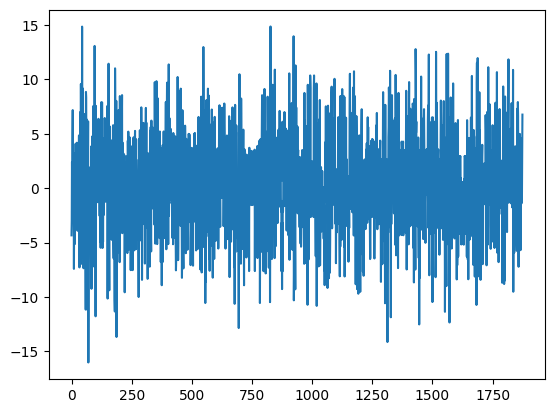

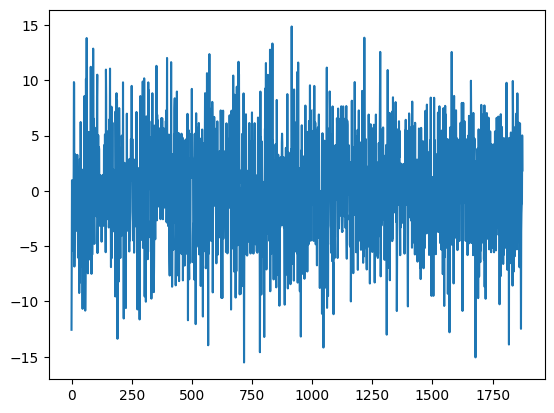

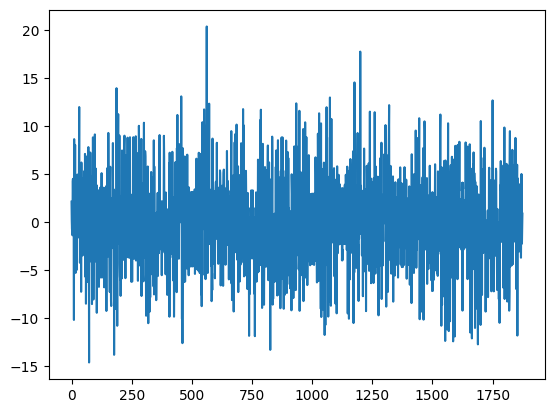

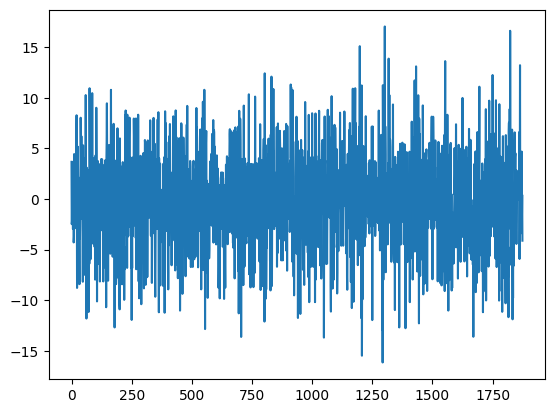

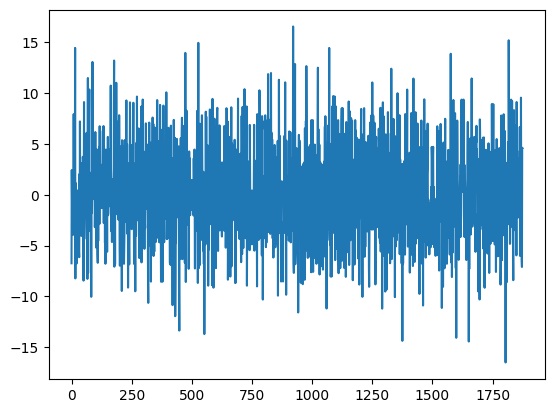

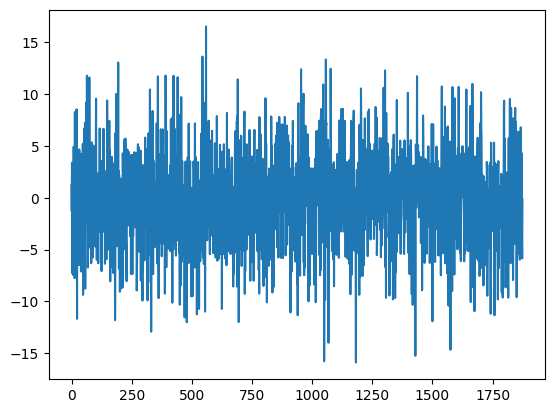

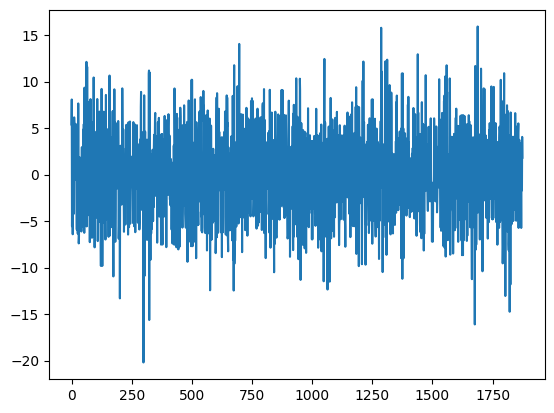

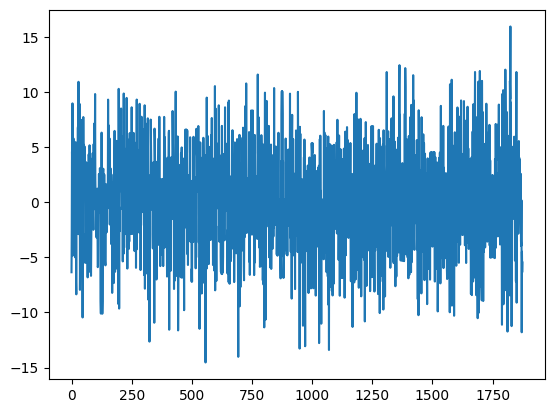

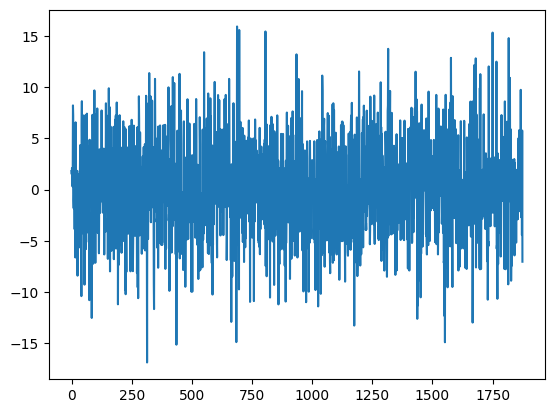

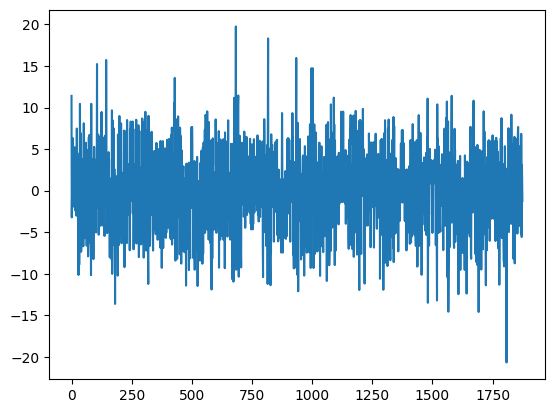

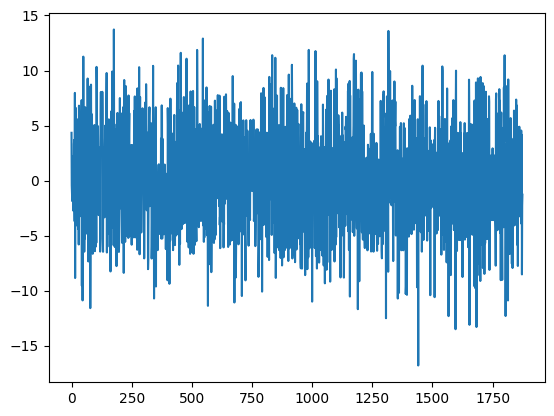

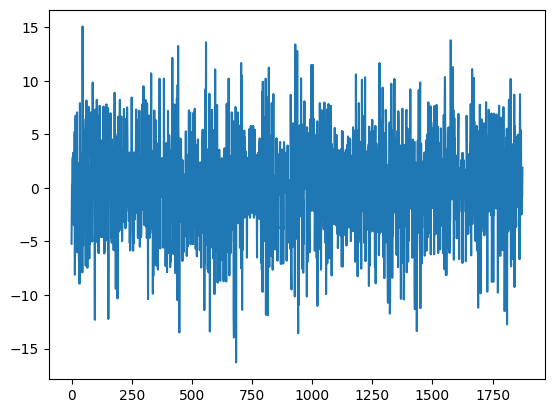

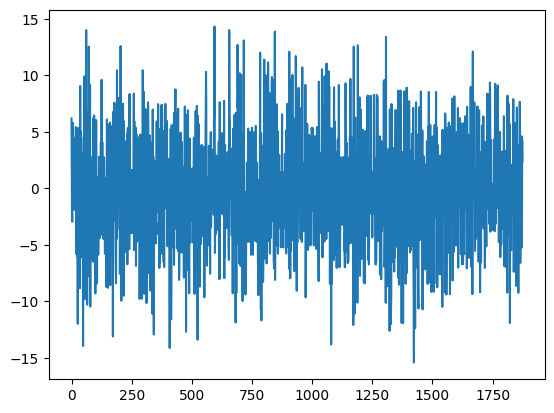

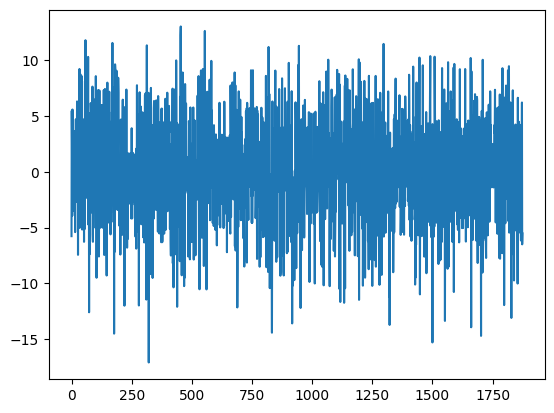

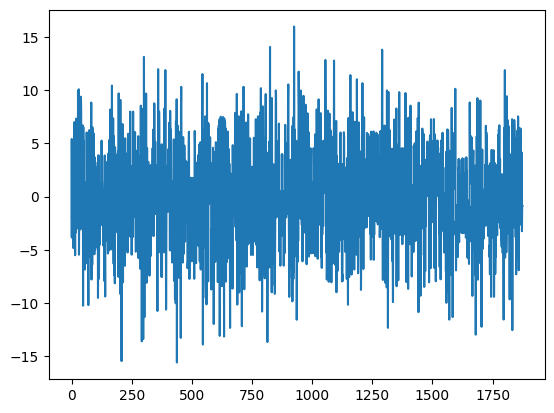

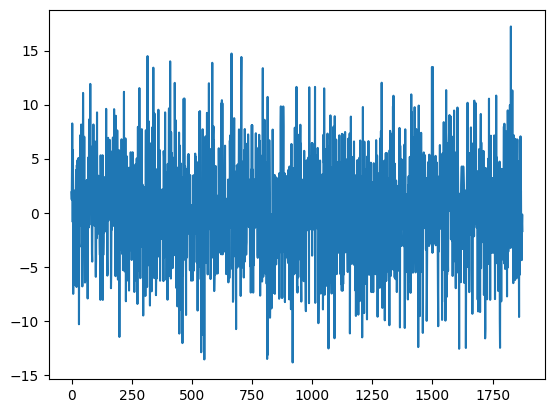

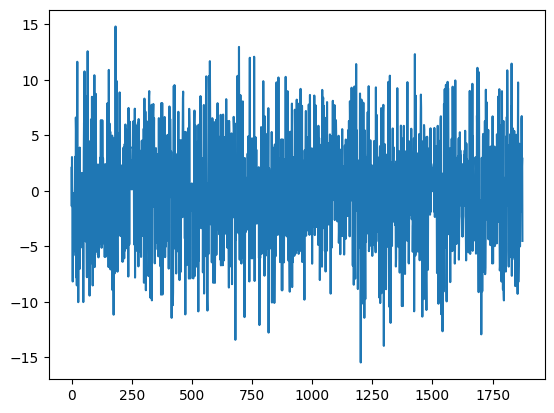

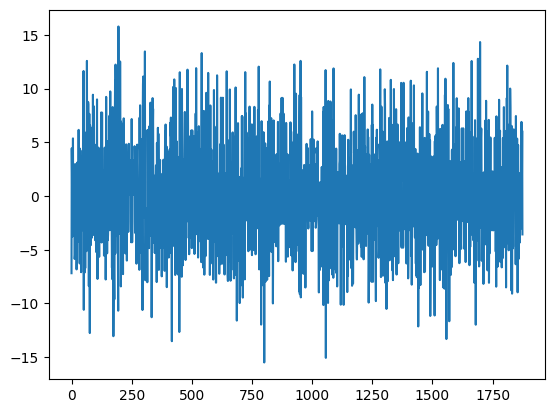

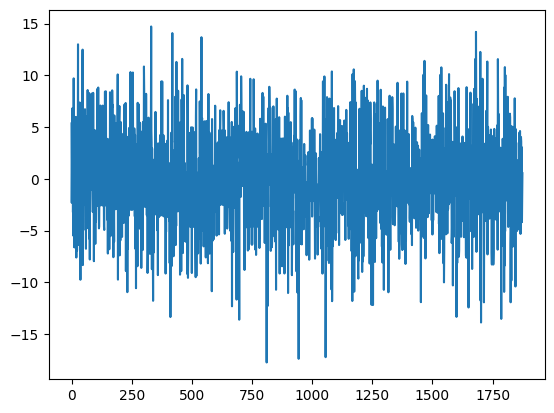

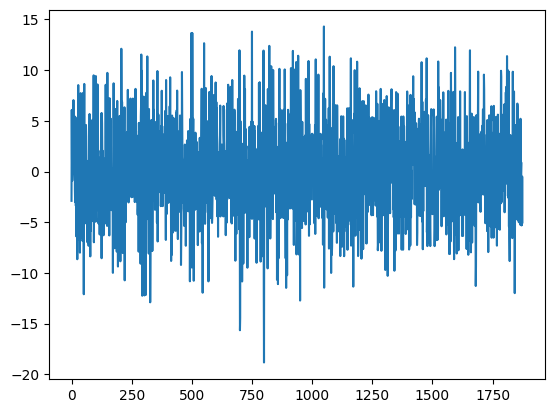

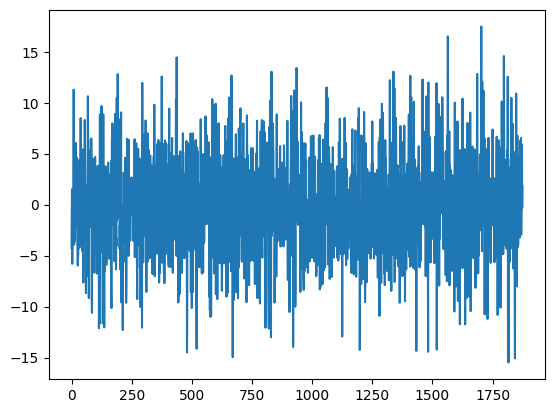

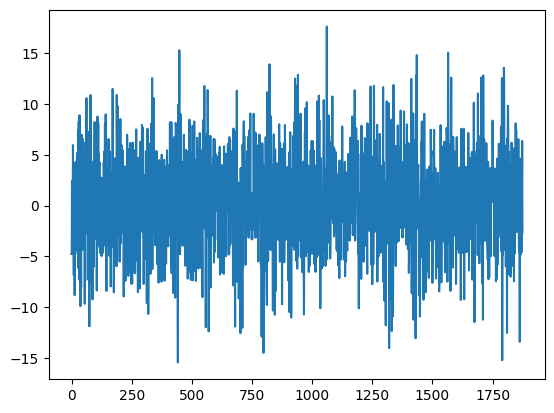

In [10]:
import matplotlib.pyplot as plt

for i in signals[0]:
    plt.plot(i)
    plt.show()